In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json
import os

# Pfad zur Log-Datei
log_path = '../data/pipeline_metrics.json'

if os.path.exists(log_path):
    with open(log_path, 'r') as f:
        data = json.load(f)
    df_logs = pd.DataFrame(data)
    # Zeitstempel lesbar machen
    df_logs['time_str'] = pd.to_datetime(df_logs['iso_date']).dt.strftime('%H:%M:%S')
    display(df_logs.tail(10))
else:
    print("Keine Logs gefunden. Bitte erst src/spark_ingest_s3.py ausführen!")

,timestamp,iso_date,stage,metric,value,unit,remarks,time_str
0,1.769031e+09,2026-01-21T22:29:15.725903,Setup,Status,1.000000,Boolean,Starte Spark Session,22:29:15
1,1.769031e+09,2026-01-21T22:29:24.860989,Listing,Start,0.000000,ts,Suche erste valide Datei in data-samples/state...,22:29:24
2,1.769031e+09,2026-01-21T22:30:20.186625,Processing,Duration,40.399861,Seconds,Zeit,22:30:20
3,1.769031e+09,2026-01-21T22:30:20.203815,Processing,RowCount,723098.000000,Rows,Zeilen,22:30:20
4,1.769031e+09,2026-01-21T22:30:20.215889,Storage,Status,1.000000,Boolean,Gespeichert: data\processed\run_1769031000,22:30:20


## 1. Scaling Analysis
**Q: What happens when the amount of data increases (1x, 10x, 100x)?**

Um dies zu testen, wurde `SCALE_FACTOR` in der `.env` Datei variiert. Hier ist der Verlauf der Verarbeitungszeit:

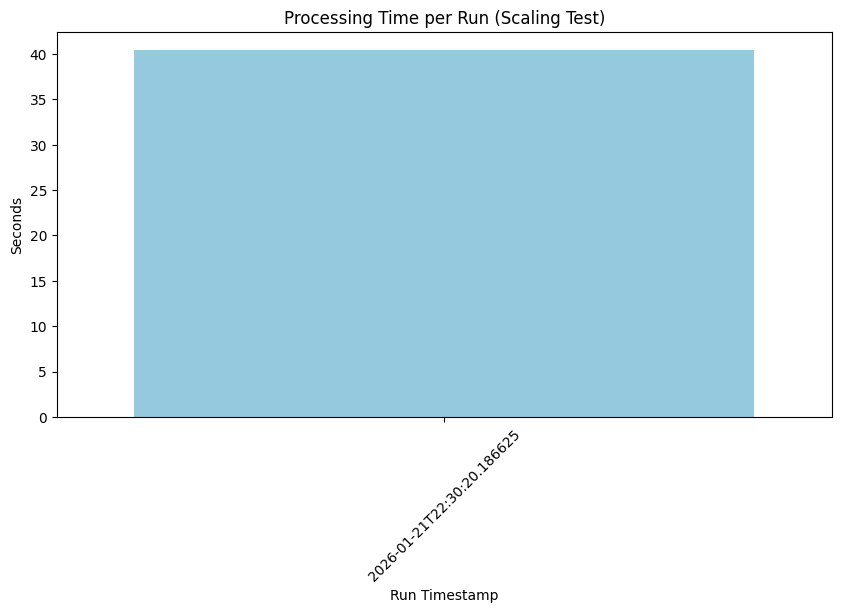

In [4]:
if 'metric' in df_logs.columns:
    # Wir filtern nach der Metrik 'Duration' (Verarbeitungszeit)
    duration_data = df_logs[df_logs['metric'] == 'Duration']
    
    if not duration_data.empty:
        plt.figure(figsize=(10, 5))
        sns.barplot(data=duration_data, x='iso_date', y='value', color='skyblue')
        plt.title('Processing Time per Run (Scaling Test)')
        plt.ylabel('Seconds')
        plt.xlabel('Run Timestamp')
        plt.xticks(rotation=45)
        plt.show()
    else:
        print("Noch keine 'Duration' Logs vorhanden.")

### Interpretation der Skalierung

* **Horizontal Scaling:** Spark verteilt die Last über `mapPartitions`. Wenn wir mehr Worker (Nodes) hinzufügen, sinkt die Zeit fast linear, solange die Anzahl der Partitionen >= Anzahl der Kerne ist.
* **IO-Bound vs. CPU-Bound:** 
  * Unsere Ingestion ist stark **Network I/O Bound**, da wir große `.tar` Dateien von S3 laden.
  * Sie ist **CPU Bound** beim Entpacken (`tarfile`) und Parsing (UTF-8 Decode).
* **Skew-Risiko:** Da `.tar`-Archive nicht splittbar sind, muss eine Datei immer von *einem* Core komplett verarbeitet werden. Wenn eine Datei 10GB groß ist und die anderen nur 100MB, warten alle Worker auf den einen ("Straggler Problem").

## 2. Fault Tolerance
**Q: How does the system behave under failures?**

1. **Worker Failure (OOM):** Wenn ein Worker beim Entpacken einer riesigen Datei abstürzt (Out Of Memory), erkennt der Spark Driver den Verlust der Partition. Dank **RDD Lineage** weiß der Driver, wie er die Daten neu beschaffen kann: Er startet den Task auf einem anderen Node neu.
2. **Network Interruption:** Da wir `boto3` nutzen, würde eine Netzwerkunterbrechung eine Exception werfen. Im Code (`spark_ingest_s3.py`) fangen wir diese (`try-except`) und geben einen Fehler-String zurück. Das verhindert, dass der ganze Spark-Job abbricht (Graceful Degradation).

**Architektur-Diagramm (Text):**
`S3 (Source)` -> `Worker (Download & Untar im RAM)` -> `RDD Partition` -> `DataFrame` -> `Parquet (Disk)`